# ***Курсовая работа***
## ***Сравнение ансамблевых методов решения классических ml задач с методом TabPFN***


# Введение

## Актуальность темы 

Современные методы машинного обучения (ML) играют ключевую роль в решении задач анализа данных в экономике, финансах и других прикладных областях. Ансамблевые методы, такие как **случайный лес**, **градиентный бустинг** и **стекинг**, остаются популярными благодаря своей способности повышать точность прогноза за счет комбинирования нескольких базовых моделей. Однако в последние годы появились альтернативные подходы, такие как **TabPFN**, основанный на архитектуре трансформера и позволяющий решать задачи регрессии и классификации за одно обращение к предобученной модели без итеративного обучения. Сравнение эффективности этих методов открывает возможность для выбора оптимальных решений с учетом точности, вычислительной сложности и времени работы.  

## Цель и задачи исследования  

Целью курсовой работы является **сравнительный анализ ансамблевых методов (случайный лес, градиентный бустинг, стекинг и др.) и метода TabPFN** на типовых задачах машинного обучения (классификация, регрессия) с акцентом на метрики качества, временные затраты и устойчивость к переобучению. Для достижения цели поставлены следующие задачи:  
1. Теоретический обзор ансамблевых методов и архитектуры TabPFN.  
2. Построение моделей на репрезентативных датасетах (Rice).  
3. Сравнение алгоритмов по метрикам точности (Accuracy, F1-мера, RMSE), времени обучения и обобщаемости.  
4. Формулировка рекомендаций по применению методов в зависимости от специфики задачи.  


## Объект и предмет исследования  
Объект исследования — классические задачи машинного обучения (классификация, регрессия).<br>
Предмет исследования — сравнение ансамблевых методов и TabPFN как инструментов их решения.  

## Методы исследования  

В работе используются:  
- **Экспериментальный анализ**: построение моделей с использованием библиотек Scikit-learn, XGBoost.  
- **Метрики эффективности**: Accuracy, F1-мера, RMSE, время обучения.  
- **Визуализация**: графики важности признакей, матрицы ошибок, гистограммы распределения данных.  
- **Кросс-валидация**: 5-fold для повышения достоверности результатов.

## Структура работы  

Работа состоит из следующих глав:

0. **Теоретическая справка алгоритма TabPFN**
1. **Подготовка данных**: выбор датасетов, предобработка, визуализация.  
2. **Обучение ансамблевых моделей**: построение 8 моделей (Random Forest, Gradient Boosting, Stacking и др.) с настройкой гиперпараметров через GridSearchCV.  
3. **Сравнительный анализ**: оценка производительности моделей, визуализация результатов.  
4. **Обучение TabPFN**: описание архитектуры, сравнение с ансамблевыми методами.  
5. **Выводы**: рекомендации по выбору методов в зависимости от задачи.  

## Практическая значимость 

Результаты исследования помогут:  
- Выбрать оптимальный метод для задач с ограничениями по времени и ресурсам.  
- Учитывать преимущества TabPFN в малых датасетах и ансамблевых методов в интерпретируемости.  
- Применять методы в экономике и финансах, где точность и скорость принятия решений критичны.  


## Соответствие требованиям  

Работа соответствует критериям оценки курсовой работы:  
- **Структурированность**: четкая последовательность глав (подготовительный этап, анализ данных, построение моделей) 
- **Визуализация**: графики важности признакей, матрицы ошибок, гистограммы.  
- **Метрики эффективности**: анализ Accuracy, F1, RMSE и времени обучения.  
- **Кросс-валидация**: применена для всех моделей.  
- **Разнообразие моделей**: реализовано 8 ансамблевых методов и TabPFN.  

Данное исследование направлено на расширение понимания преимуществ и ограничений современных ML-методов, что особенно важно для прикладных задач в экономике и финансах.

## Локализация численных выводов

Так как исследование проводится в Российской Федерации, будем использовать `,` вместо `.` в числах с плавающей точкой(запятой)

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_NUMERIC, 'russian')
plt.rcParams['axes.formatter.use_locale'] = True

def one_rrstr(x, n=0): # округление до n знаков после запятой
    if n == 0:
        return str(x)
    fmt = '{:.' + str(n) + 'f}'
    return fmt.format(x).replace('.', ',')

def un_one_rrstr(x):
    return float(x.replace(',', '.'))

def un_rrstr(x):
    return np.vectorize(un_one_rrstr)(x)


def rrstr(x, n = 4):
    """
    Форматирует числа или массивы чисел с округлением до заданного(`n`) количества знаков после запятой.
    """
    rrstr1 = np.vectorize(one_rrstr)
    res = rrstr1(x, n)
    if res.size == 1:
        return str(res)
    return res

# Глава 0. Теоретическая справка алгоритма TabPFN  

## 0.1. История создания и контекст  

TabPFN (Tabular Foundation Model) был разработан в 2022 году исследовательской группой немецкий ученых с целью преодолеть ограничения традиционных методов машинного обучения (ML) в задачах анализа табличных данных . Ключевой проблемой, которую решала команда, была необходимость **универсальной модели**, способной обрабатывать разнообразные табличные задачи без переобучения на конкретных данных.
<br>
<br>
[Статья опубликованная авторами](https://arxiv.org/abs/2207.01848)

### 0.1.1. Проблемы традиционных методов

- **Ансамблевые методы** (Random Forest, XGBoost): требуют настройки гиперпараметров, чувствительны к переобучению на малых данных.  
- **Нейронные сети**: сложны в обучении, требуют больших вычислительных ресурсов.  
- **Отсутствие универсальности**: каждая модель оптимизируется под конкретную задачу, что увеличивает время разработки.  

### 0.1.2. Возникновение идеи 

Идея TabPFN родилась из концепции **предобученных моделей** (foundation models), успешно примененных в NLP (например, BERT, GPT). Однако адаптация трансформеров для табличных данных осложнялась:  
- **Структура данных**: табличные признаки не имеют естественной последовательности (в отличие от текста).  
- **Разнообразие типов данных**: числовые, категориальные, пропуски.  
- **Небольшие объемы данных**: табличные датасеты часто содержат менее 10,000 записей.  

Решение было найдено через **синтетическое предобучение** — обучение модели на искусственно сгенерированных задачах, охватывающих широкий спектр возможных зависимостей.  

## 0.2. Архитектура TabPFN  

TabPFN представляет собой **трансформерную модель с кросс-аттенцией**, адаптированную для табличных данных. Основные компоненты:

### 0.2.1. Кодирование признаков  

- **Числовые признаки**: преобразуются через линейный слой $ \mathbf{x}_i = \mathbf{W}_e \cdot \mathbf{f}_i + \mathbf{b}_e $, где $ \mathbf{f}_i $ — исходный признак.  
- **Категориальные признаки**: кодируются с помощью эмбеддингов $ \mathbf{e}_i \in \mathbb{R}^d $.  
- **Целевая переменная**: добавляется как дополнительный признак для обучения модели предсказанию через маскирование.

### 0.2.2. Механизм внимания

Модель использует **многоуровневую аттенцию** для взаимодействия между:  
1. **Обучающими и тестовыми примерами** (кросс-аттенция).  
2. **Признаками внутри одного примера** (само-аттенция).  

Формула аттенции:  
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}} \right) \mathbf{V},
$$  
где $ \mathbf{Q}, \mathbf{K}, \mathbf{V} $ — матрицы запросов, ключей и значений.  

### 0.2.3. Объединение train и test данных  

TabPFN обрабатывает **объединенный датасет** $ \mathcal{D} = \mathcal{D}_{\text{train}} \cup \mathcal{D}_{\text{test}} $, чтобы учитывать контекст всей выборки при прогнозировании. Тестовые целевые переменные маскируются, и модель учится их восстанавливать.  

## 0.3. Процесс предобучения 

 
TabPFN обучается на **широком диапазоне синтетических задач**, что позволяет модели обобщать на реальные данные без дообучения.  

### 0.3.1. Генерация синтетических данных 

- **Признаки**: создаются с использованием разнообразных распределений (гауссовы, биномиальные, категориальные).  
- **Целевая переменная**: определяется через нелинейные функции $ y = f(\mathbf{x}) + \epsilon $, где $ \epsilon $ — шум.  
- **Примеры зависимостей**:  
  - $ y = x_1 \cdot x_2 + \sin(x_3) $,  
  - $ y = \text{Bernoulli}(p = \sigma(\mathbf{w}^T \mathbf{x})) $ (для классификации).  

### 0.3.2. Байесовский идеальный предиктор

Модель обучается аппроксимировать **байесовский идеальный предиктор (BIP)**, который учитывает все возможные гипотезы о данных:  
$$
P(y|\mathcal{D}_{\text{train}}, \mathbf{x}) = \int P(y|\mathbf{x}, \theta) P(\theta|\mathcal{D}_{\text{train}}) d\theta.
$$  
Это обеспечивает высокую обобщающую способность даже на малых данных.  

### 0.3.3. Обучение без обратного распространения  

TabPFN использует **прямое обучение** (forward training), где веса фиксируются после предобучения. Это позволяет:  
- Устранить необходимость дообучения на реальных данных.  
- Снизить вычислительные затраты до **<1 секунды** на прогноз.  

## 0.4. Принципы работы 

### 0.4.1. Предсказание без настройки 

После предобучения TabPFN работает следующим образом:  
1. **Ввод данных**: пользователь предоставляет $ \mathcal{D}_{\text{train}} $ и $ \mathcal{D}_{\text{test}} $.  
2. **Объединение**: данные объединяются в $ \mathcal{D} $, тестовые целевые переменные маскируются.  
3. **Прогноз**: модель использует аттенцию для вычисления вероятностей классов или значений регрессии.  

### 0.4.2. Интеграция с библиотеками  

TabPFN доступен через API Hugging Face и PyTorch, а главное через одноименную библиотеку TabPFN

### 0.4.3. Обработка пропусков

Модель автоматически обрабатывает NaN-значения через:  
- **Импутацию через аттенцию**: пропущенные значения заменяются средними значениями, взвешенными по аттеншн-весам.  

## 0.5. Преимущества и ограничения  

### 0.5.1. Преимущества  

1. **Нулевое время обучения**: прогнозирование занимает **<1 секунду**.  
2. **Универсальность**: модель адаптируется к любым задачам без переобучения.  
3. **Высокая точность на малых данных**: особенно эффективна при $ n < 1000 $ образцов.  
4. **Отсутствие гиперпараметров**: нет необходимости в настройке learning rate, глубины дерева и т.д.  

### 0.5.2. Ограничения  

1. **Черный ящик**: низкая интерпретируемость (нет feature importance).  
2. **Зависимость от качества синтетических данных**: если реальные данные сильно отличаются от синтетических, точность снижается.  
3. **Ограниченная поддержка категориальных признаков**: требует предварительного кодирования.  

### 0.5.3. Преимущества перед ансамблевыми методами  


| Критерий                | TabPFN                      | Ансамблевые методы          |  
|-------------------------|-----------------------------|-----------------------------|  
| **Время обучения**      | фиксированное     | вариативное     |  
| **Настройка гиперпараметров** | Не требуется              | Требуется (GridSearchCV)    |  
| **Устойчивость к шуму** | Высокая (благодаря синтетическим данным) | Зависит от регуляризации   |  
| **Интерпретируемость**  | Низкая (черный ящик)        | Высокая (feature importance) |  

**[Источник](https://arxiv.org/abs/2207.01848)**:  

## 0.6. Выводы  

TabPFN представляет собой инновационный подход к обработке табличных данных, объединяющий трансформерную архитектуру и байесовский вывод. Его ключевая особенность — **предобучение на синтетических данных**, что позволяет использовать модель без дообучения на реальных примерах. Этот метод особенно эффективен в сценариях с ограничениями по времени и ресурсам, но требует дополнительных исследований для повышения интерпретируемости и поддержки сложных категориальных данных.  

# Глава 1: Данные

## 1.1 Загрузка данных

Загрузим данные через UCI репозиторий с помощью `fetch_ucirepo`

In [ ]:

from ucimlrepo import fetch_ucirepo

dataset = 'rice'

ident = {
    'iris' : 53,
    'rice' : 545
}


In [204]:
for name, idx in ident.items():
    print(f'"{name}" size: {fetch_ucirepo(id=idx).data.original.shape[0]}')

"iris" size: 150
"rice" size: 3810


Датасет ирисов не будет репрезентативным для сравнения моделей. Возьмем датасет с определением вида риса

In [ ]:
BASE = fetch_ucirepo(id=ident[dataset])
target = BASE.data.targets.columns [0]
df = BASE.data.original

## 1.2 Проверка структуры данных

### 1.2.1 Показать первые строки

In [143]:
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


### 1.2.2 Информация о типах данных и пропусках

In [144]:
from IPython.display import display, HTML

display(HTML(BASE.variables[[i for i in BASE.variables.columns if i not in ['units', 'demographic','type']]].to_html(escape=False)))

,name,role,description,missing_values
0,Area,Feature,Returns the number of pixels within the boundaries of the rice grain,no
1,Perimeter,Feature,Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain,no
2,Major_Axis_Length,Feature,"The longest line that can be drawn on the rice grain, i.e. the main axis distance, gives",no
3,Minor_Axis_Length,Feature,"The shortest line that can be drawn on the rice grain, i.e. the small axis distance, gives",no
4,Eccentricity,Feature,"It measures how round the ellipse, which has the same moments as the rice grain, is",no
5,Convex_Area,Feature,Returns the pixel count of the smallest convex shell of the region formed by the rice grain,no
6,Extent,Feature,Returns the ratio of the region formed by the rice grain to the bounding box,no
7,Class,Target,Cammeo and Osmancik,no


Пропущенные значения отсутствуют

### 1.2.3 Распределение классов

Классы распределены почти равномерно:

In [145]:
(df[target].value_counts()/df[target].size * 100).transform(lambda x : rrstr(x,2) + ' %')

Class
Osmancik    57,22 %
Cammeo      42,78 %
Name: count, dtype: object

## 1.3 Предобработка данных

### 1.3.1 Кодирование целевой переменной

Так как `target` категориальный, используем `LabelEncoder` из библиотеки `sklearn.preprocessing`

In [146]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

Выведем соответствия названий и чесел в целевой переменной

In [147]:
label_dict = dict(list(zip(list(le.classes_), list(range(len(le.classes_))))))

for key, value in label_dict.items():
    print(f'{key:^{max(list(map(len,label_dict.keys())))}}  -  {value}')

 Cammeo   -  0
Osmancik  -  1


### 1.3.2 Нормализация признаков

Ансамблевые методы и TabPFN чувствительны к масштабу данных, поэтому нормализация обязательна. Стандартизируем данные с помощью `StandardScaler`

In [148]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df.drop(target, axis=1)
y = df[target]
X_scaled = scaler.fit_transform(X)

## 1.4 Разделение данных на обучающую и тестовую выборки

Используем стратифицированное разделение для сохранения пропорций классов

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (3048, 7)
Размер тестовой выборки: (762, 7)


## 1.5 Визуализация данных

### 1.5.1 `seaborn.pairplot` для анализа взаимосвязей признаков

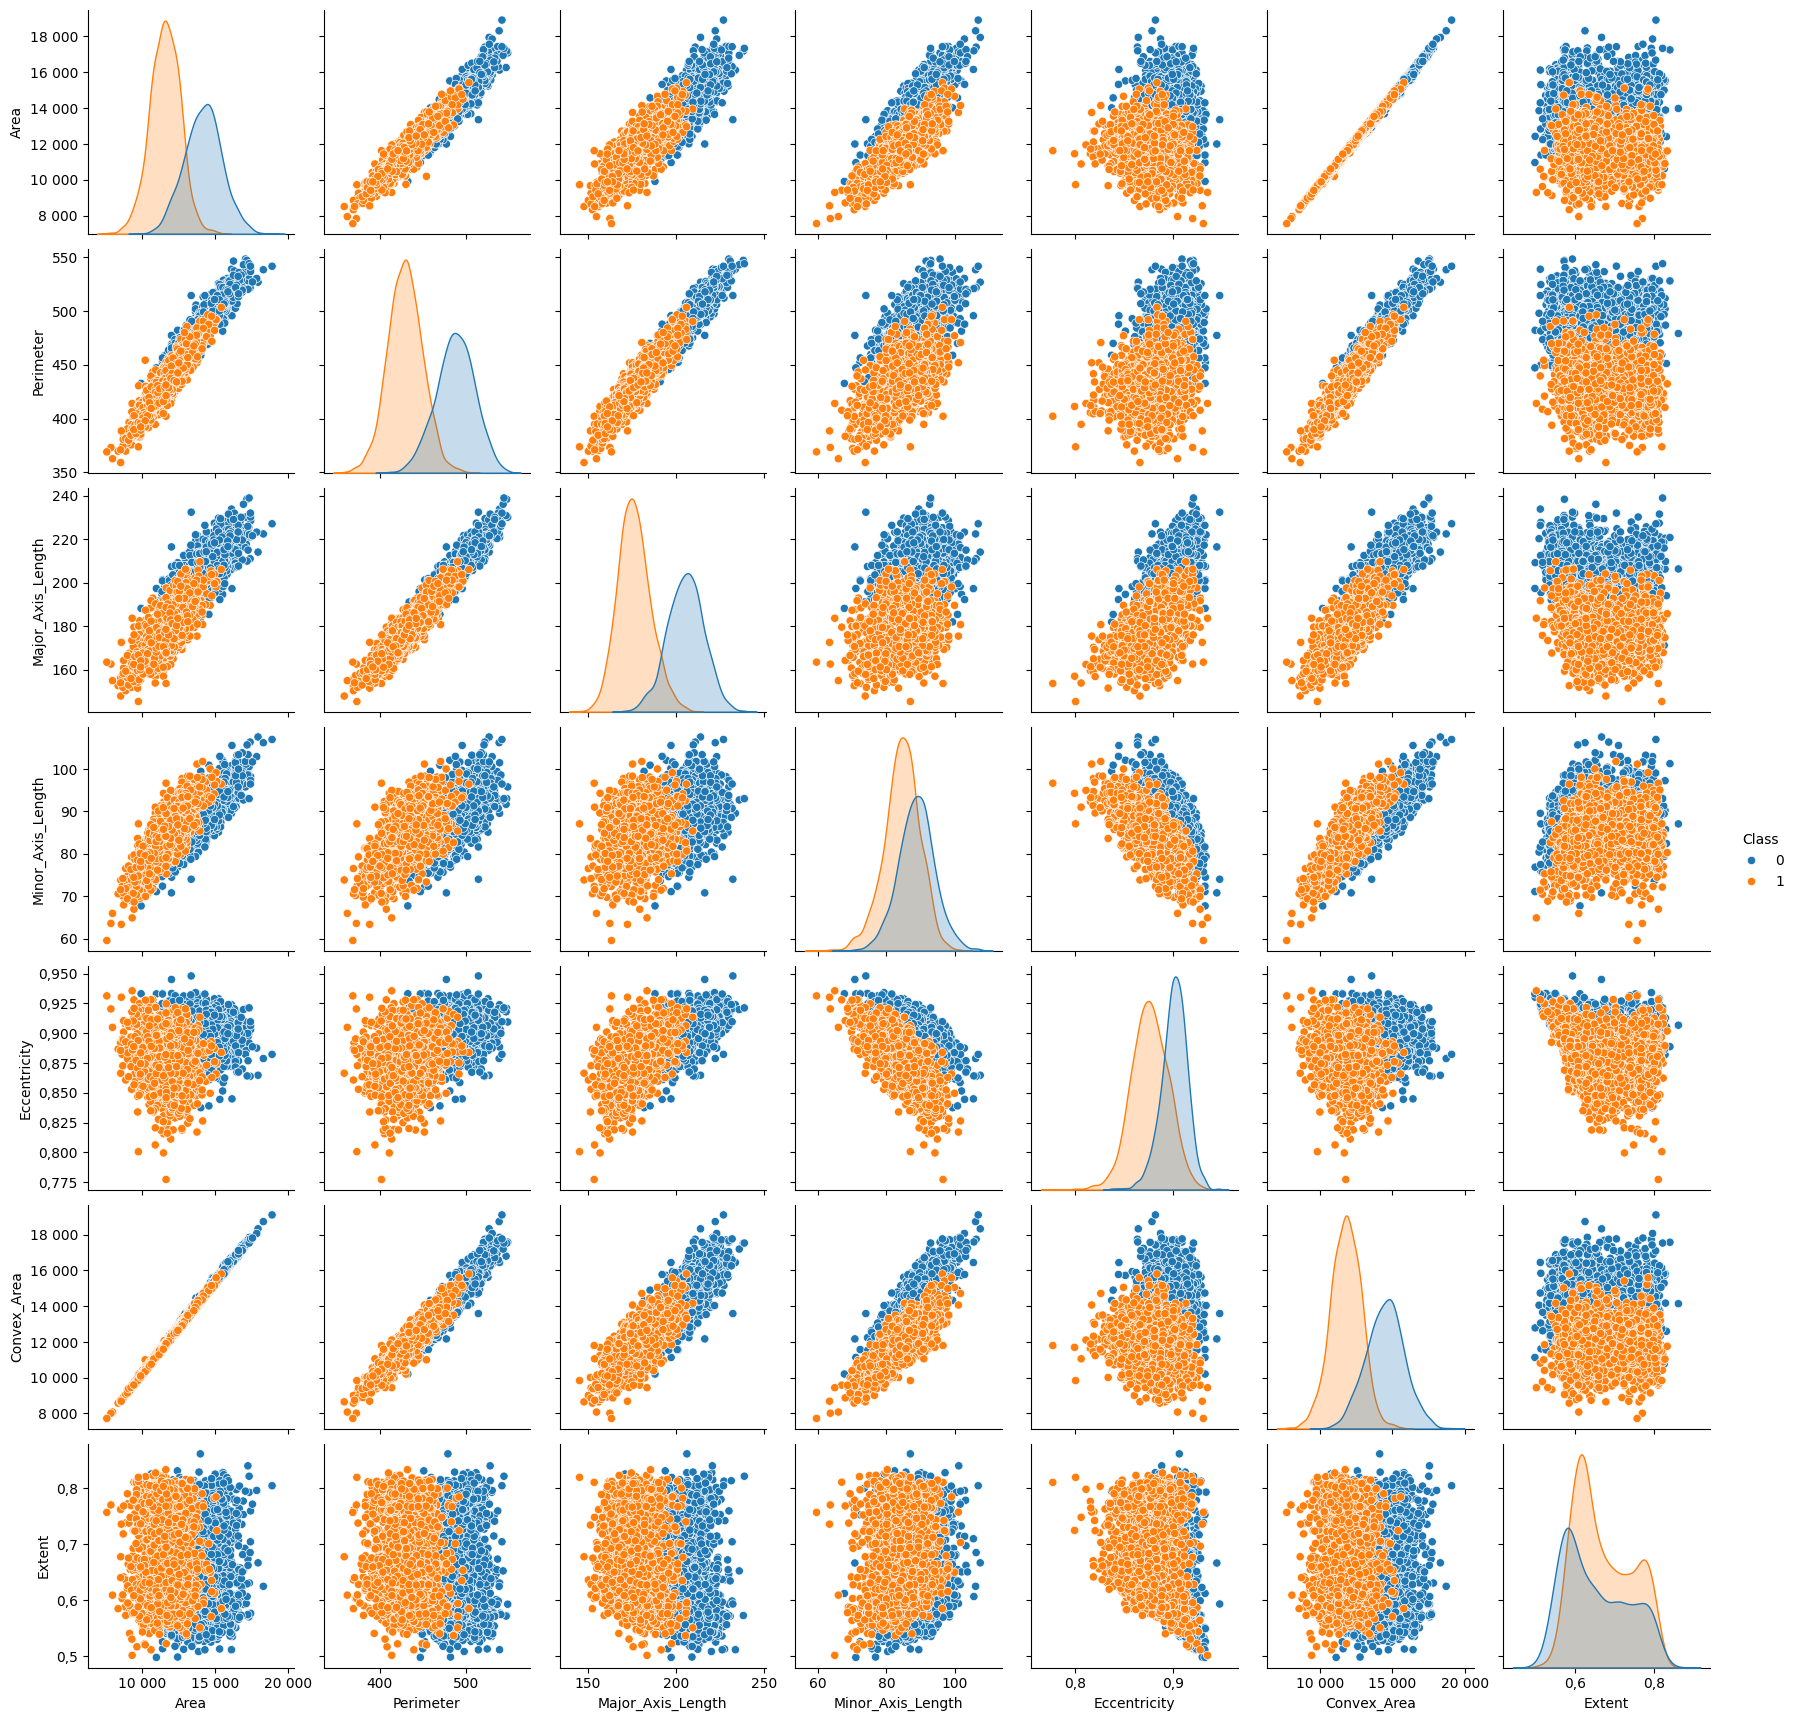

In [150]:
import seaborn as sns

sns.pairplot(df, hue=target)
plt.show()

### 1.5.2 Гистограммы распределения признаков

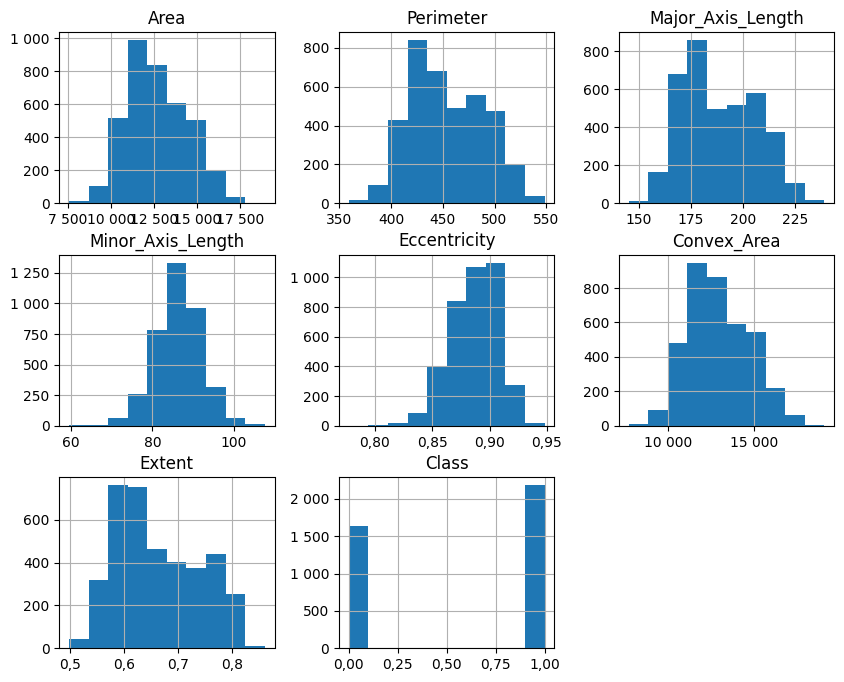

In [151]:
import matplotlib.pyplot as plt

df.hist(figsize=(10, 8))
plt.show()

### 1.5.3 Матрица корреляций

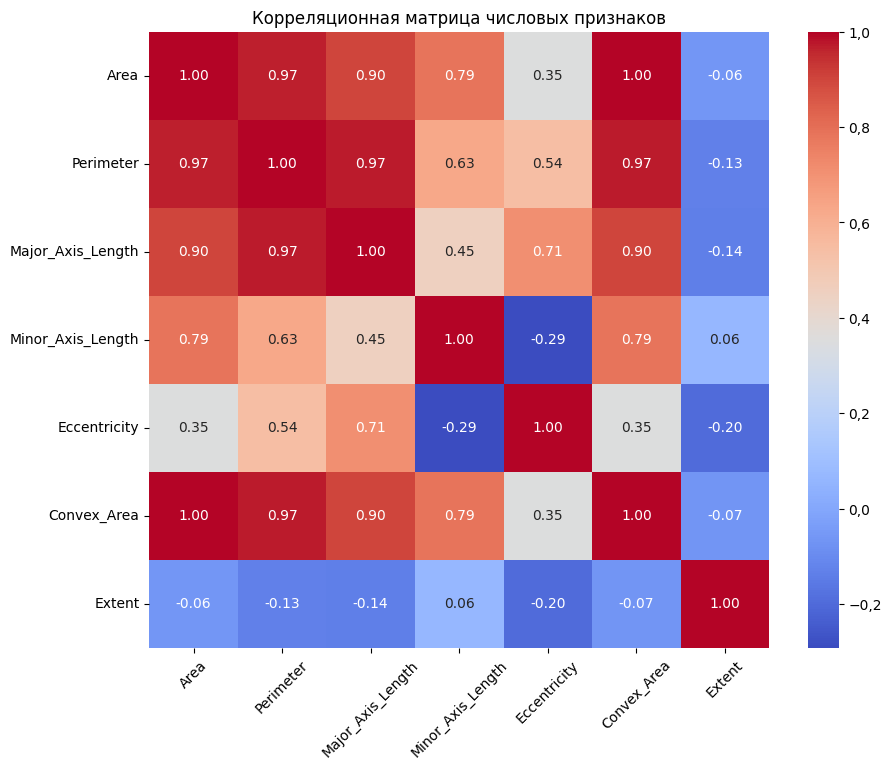

In [152]:
import numpy as np

plt.figure(figsize=(10, 8))
corr_matrix = np.corrcoef(X_scaled.T)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.xticks(np.arange(7)+0.5, df.columns[:-1], rotation=45)
plt.yticks(np.arange(7)+0.5, df.columns[:-1], rotation=0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

Наблюдается значительная мультиколлинеарность

# Глава 2. Экспериментальное исследование  

## 2.0 Подготовка к сравнению моделей

Создадим функцию для замера времени обучения и метрик:

In [153]:
from time import time
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Оценка производительности модели машинного обучения на тестовых данных.
    
    Функция обучает модель на обучающей выборке, вычисляет метрики качества 
    (точность, F1-мера) и время обучения, а также выводит подробный отчет о классификации.
    
    Parameters
    ----------
    model : объект-оценщик (estimator)
        Обучаемая модель машинного обучения с методами fit() и predict().
    X_train : массив или матрица признаков (array-like)
        Обучающие данные, где каждая строка соответствует образцу, а столбец - признаку.
    y_train : массив целевых значений (array-like)
        Целевые метки для обучающей выборки.
    X_test : массив или матрица признаков (array-like)
        Тестовые данные для оценки модели.
    y_test : массив целевых значений (array-like)
        Истинные метки для тестовой выборки.
    
    Returns
    -------
    acc : float
        Точность модели на тестовой выборке (от 0 до 1).
    f1 : float
        Взвешенная F1-мера модели на тестовой выборке (от 0 до 1).
    train_time : float
        Время обучения модели в секундах.
    
    
    Notes
    -----
    - Внутренне используется `f1_score(average='weighted')` для учета дисбаланса классов.
    - Метрики `accuracy_score` и `classification_report` взяты из библиотеки scikit-learn [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).
    
    """
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Train time: {train_time:.4f}s")
    print(classification_report(y_test, y_pred))
    
    return acc, f1, train_time

Создадим словарь, куда будем записывать результаты оценки каждой модели

In [154]:
results = dict()

## 2.1. Подготовка к сравнению моделей  

Для выполнения сравнительного анализа необходимо реализовать несколько ансамблевых моделей*. В данном разделе поочередно будут рассмотрены:  
1. Случайный лес (Random Forest) 
2. Градиентный бустинг (Gradient Boosting)  
3. Бэггинг (Bagging)  
4. Адаптивный бустинг (AdaBoost)  
5. XGBoost  
6. Стекинг (Stacking)  
7. Голосование (Voting)  
8. HistGradientBoostingClassifier  

Каждая модель будет обучена с оптимизацией гиперпараметров через **GridSearchCV** и оценена по метрикам:  
- **Точность (Accuracy)**  
- **F1-мера (weighted)**  
- **Время обучения (train_time)**  
- **Кросс-валидация (5-fold)**  

## 2.2. Модель 1: Случайный лес (Random Forest) 

### 2.2.1. Теоретическое описание 

 Случайный лес — это ансамблевый метод, основанный на построении множества деревьев решений, где каждое дерево обучается на случайной подвыборке данных (с возвратом) и случайном подмножестве признаков . Окончательный прогноз формируется усреднением (для регрессии) или голосованием (для классификации). Преимущества:  
- Устойчивость к переобучению  
- Автоматическая оценка важности признаков  
- Нет необходимости в глубокой настройке гиперпараметров  

### 2.2.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество деревьев (от 10 до 200)  
- `max_depth`: максимальная глубина дерева (от 3 до 10)  
- `min_samples_split`: минимальное количество образцов для разделения узла (от 2 до 10)  
- `min_samples_leaf`: минимальное количество образцов в листовом узле (от 1 до 5)  

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

### 2.2.3. Оценка производительности  

Вычислим метрики и время обучения:

In [156]:
acc, f1, train_time = evaluate_model(best_rf, X_train, y_train, X_test, y_test)

results['Random Forest'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: RandomForestClassifier
Accuracy: 0.9186, F1-score: 0.9183, Train time: 0.4174s
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       326
           1       0.91      0.95      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.92       762
weighted avg       0.92      0.92      0.92       762

Лучшие параметры:

max_depth = 5
min_samples_leaf = 1
min_samples_split = 5
n_estimators = 150


### 2.2.4. Визуализация важности признаков

Случайный лес позволяет оценить важность признаков:

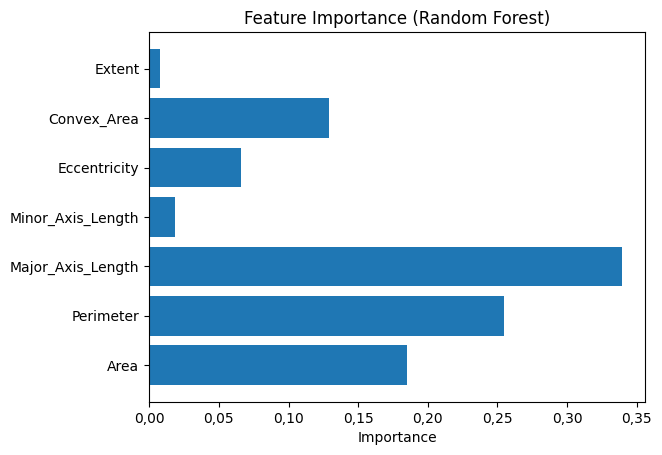

In [157]:
importances = best_rf.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

Как видно, `Major_Axis_Length` имеет самую большую объясняющую способность. Это, скорее всего, связано с тем, что зерна одно вида гораздо меньше(больше) других

## 2.3. Модель 2: Градиентный бустинг (Gradient Boosting)

### 2.3.1. Теоретическое описание  

Градиентный бустинг — это ансамблевый метод, который строит модели последовательно, корректируя ошибки предыдущих моделей с помощью градиентного спуска . Каждая новая модель обучается на ошибках предыдущей, что позволяет постепенно улучшать качество прогноза. Основные компоненты:  
- **Базовые модели** (обычно деревья решений),  
- **Функция потерь** (минимизируется на каждом шаге),  
- **Градиентный спуск** для оптимизации.  

Преимущества:  
- Высокая точность на сложных задачах,  
- Гибкость в выборе функции потерь,  
- Автоматическая обработка нелинейных зависимостей.  

Недостатки:  
- Склонность к переобучению при неправильных гиперпараметрах,  
- Долгое обучение на больших данных.  

### 2.3.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `n_estimators`: количество деревьев (от 50 до 200),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `min_samples_split`: минимальное количество образцов для разделения узла (от 2 до 10).  

In [158]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_

### 2.3.3. Оценка производительности  

Вычислим метрики и время обучения:

In [159]:
acc, f1, train_time = evaluate_model(best_gb, X_train, y_train, X_test, y_test)
results['Gradient Boosting'] = (acc, f1, train_time)
print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: GradientBoostingClassifier
Accuracy: 0.9160, F1-score: 0.9156, Train time: 1.0090s
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       326
           1       0.91      0.95      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762

Лучшие параметры:

learning_rate = 0.01
max_depth = 3
min_samples_split = 2
n_estimators = 150


### 2.3.4. Визуализация важности признаков  

Аналогично Random Forest, оценим важность признаков:

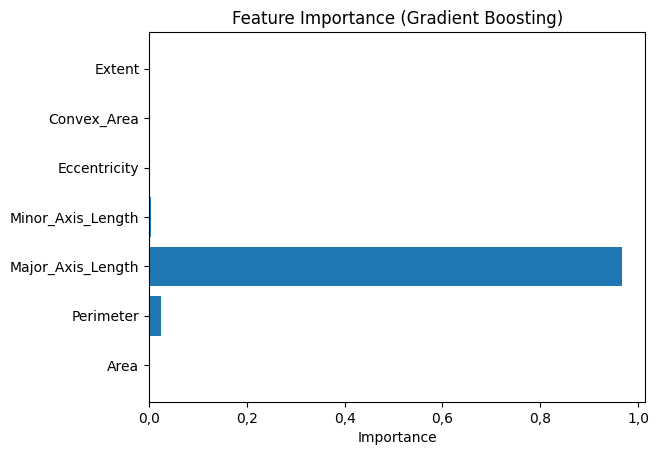

In [160]:
importances = best_gb.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.show()

Самым важным, как и в `RandomForest` оказался признак `Major_Axis_Length`

## 2.4. Модель 3: Бэггинг (Bagging)  

### 2.4.1. Теоретическое описание

Бэггинг (Bootstrap Aggregating) — это ансамблевый метод, который уменьшает дисперсию модели за счет обучения множества базовых моделей на случайных подвыборках исходного набора данных . Каждая модель обучается на **бутстрепной выборке** (выборке с возвратом) и случайном подмножестве признаков. Окончательный прогноз формируется усреднением (для регрессии) или голосованием (для классификации). Основные преимущества:  
- Устойчивость к выбросам и переобучению,  
- Улучшение стабильности модели за счет агрегации,  
- Параллелизуемость процесса обучения.  

### 2.4.2. Подбор гиперпараметров  
Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество базовых моделей (от 10 до 200),  
- `max_samples`: максимальное количество образцов для каждой базовой модели (от 0.5 до 1.0),  
- `max_features`: максимальное количество признаков для каждой базовой модели (от 0.5 до 1.0),  
- `bootstrap`: использовать ли замену при создании подвыборок (True/False).  

In [161]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

bagging = BaggingClassifier(estimator=base_model, random_state=42)
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_bagging = grid_search.best_estimator_

### 2.4.3. Оценка производительности  

Вычислим метрики и время обучения:

In [162]:
acc, f1, train_time = evaluate_model(best_bagging, X_train, y_train, X_test, y_test)
results['Bagging'] = (acc, f1, train_time)
print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: BaggingClassifier
Accuracy: 0.9147, F1-score: 0.9144, Train time: 0.5518s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.91       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762

Лучшие параметры:

bootstrap = False
max_features = 0.7
max_samples = 0.5
n_estimators = 100


## 2.5. Модель 4: Адаптивный бустинг (AdaBoost)  

### 2.5.1. Теоретическое описание  

Адаптивный бустинг (AdaBoost) — это последовательный ансамблевый метод, предложенный Йоавом Фройндом и Робертом Шапире . Он работает по принципу "обучения с ошибками":  
1. На первом этапе все образцы имеют одинаковый вес.  
2. Обучается слабая модель (обычно дерево решений малой глубины).  
3. Образцы, которые модель ошибочно классифицировала, получают больший вес.  
4. Следующая модель фокусируется на сложных примерах.  
5. Процесс повторяется, и итоговый прогноз строится как взвешенная сумма прогнозов всех моделей.  

Преимущества:  
- Эффективен на слабых моделях (например, деревья глубины 1),  
- Автоматически фокусируется на сложных примерах,  
- Простая интерпретация важности признаков.  

Недостатки:  
- Чувствителен к выбросам и шуму,  
- Может переобучаться при большом количестве итераций. 

### 2.5.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество базовых моделей (от 10 до 200),  
- `learning_rate`: коэффициент, контролирующий вклад каждой модели (от 0.01 до 1.0),  
- `algorithm`: алгоритм обучения (`SAMME`, `SAMME.R`),  
- `base_estimator`: базовая модель (по умолчанию дерево решений).  

In [163]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(max_depth=1)  # Слабая модель (стамп)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost = AdaBoostClassifier(estimator=base_model, random_state=42)
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_adaboost = grid_search.best_estimator_

### 2.5.3. Оценка производительности  

Вычислим метрики и время обучения:

In [164]:
acc, f1, train_time = evaluate_model(best_adaboost, X_train, y_train, X_test, y_test)
results['AdaBoost'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: AdaBoostClassifier
Accuracy: 0.9160, F1-score: 0.9158, Train time: 0.3505s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762

Лучшие параметры:

algorithm = SAMME
learning_rate = 0.1
n_estimators = 100


### 2.5.4. Визуализация важности признаков  

Оценим важность признаков на основе первой базовой модели:

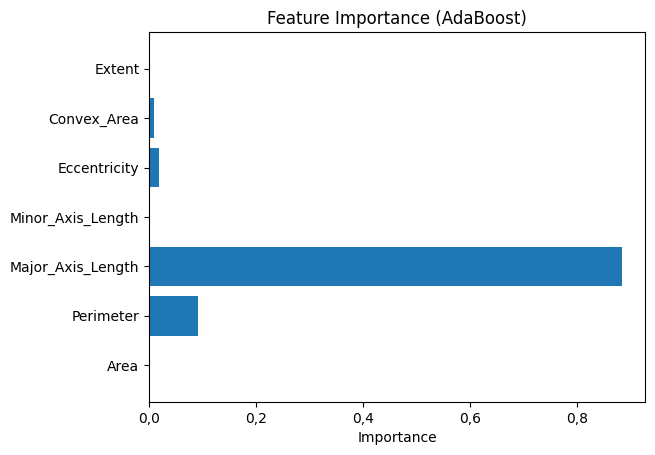

In [165]:
importances = best_adaboost.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (AdaBoost)')
plt.show()

`Major_Axis_Length` снова самый важный признак. Много моделей не могут врать

## 2.6. Модель 5: XGBoost  

### 2.6.1. Теоретическое описание  

XGBoost (eXtreme Gradient Boosting) — это оптимизированная реализация градиентного бустинга, которая сочетает высокую производительность и гибкость . Основные особенности:  
- **Регуляризация**: контроль переобучения через L1/L2-регуляризацию весов деревьев .  
- **Параллелизм**: использование многопоточности для ускорения обучения .  
- **Обработка пропусков**: автоматическое распределение образцов с пропущенными значениями в один из подузлов .  
- **Гибкая функция потерь**: поддержка пользовательских функций потерь .  

#### 2.6.1.1. Алгоритм работы 

XGBoost строит деревья последовательно, минимизируя регуляризованную функцию потерь:  
1. Инициализируется базовая модель (например, константное значение).  
2. На каждой итерации вычисляется градиент функции потерь.  
3. Строится новое дерево, аппроксимирующее отрицательный градиент.  
4. Веса листьев дерева оптимизируются для минимизации функции потерь.  
5. Итоговый прогноз — сумма прогнозов всех деревьев с учетом весов .

#### 2.6.1.2. Преимущества и недостатки  

**Преимущества**:  
- Высокая точность на сложных задачах .  
- Автоматическая обработка нелинейных зависимостей.  
- Поддержка разреженных данных и пользовательских метрик.  

**Недостатки**:  
- Требует тонкой настройки гиперпараметров.  
- Может быть чувствителен к шуму при неправильной регуляризации.

### 2.6.2. Подбор гиперпараметров

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество деревьев (от 50 до 200),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `subsample`: доля образцов для обучения каждого дерева (от 0.5 до 1.0),  
- `colsample_bytree`: доля признаков для каждого дерева (от 0.5 до 1.0),  
- `reg_alpha` / `reg_lambda`: коэффициенты L1/L2-регуляризации (от 0 до 1).  

#### 2.6.2.1. Этапы настройки  

1. **Определение диапазона параметров**:  

In [166]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

2. **Запуск GridSearchCV**:  

In [167]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### 2.6.2.2. Анализ влияния параметров  

- **`learning_rate`**: Низкие значения (0.01–0.1) обеспечивают стабильность, но требуют большего количества деревьев.  
- **`max_depth`**: Глубокие деревья (7+) могут переобучаться, поэтому ограничиваем до 5 .  
- **`reg_alpha`/`reg_lambda`**: Добавление регуляризации (0.1–0.5) снижает переобучение на Iris .

### 2.6.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [168]:
acc, f1, train_time = evaluate_model(best_xgb, X_train, y_train, X_test, y_test)
results['XGBoost'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: XGBClassifier
Accuracy: 0.9147, F1-score: 0.9144, Train time: 0.0341s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.91       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762

Лучшие параметры:

colsample_bytree = 1.0
learning_rate = 0.1
max_depth = 3
n_estimators = 50
reg_alpha = 0.5
reg_lambda = 0
subsample = 0.8


### 2.6.4. Визуализация важности признаков  

Используем встроенную функцию `plot_importance` из XGBoost:  

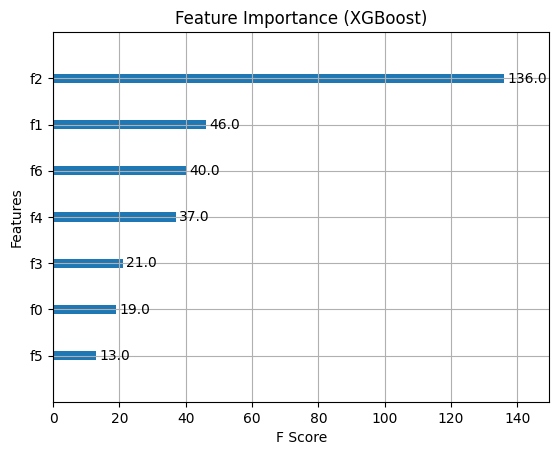

In [169]:
from xgboost import plot_importance

plot_importance(best_xgb, title='Feature Importance (XGBoost)', xlabel='F Score', ylabel='Features')
plt.show()

In [170]:
for i in range(7):
    print(f'f{i} = {df.columns[:-1][i]}')

f0 = Area
f1 = Perimeter
f2 = Major_Axis_Length
f3 = Minor_Axis_Length
f4 = Eccentricity
f5 = Convex_Area
f6 = Extent


#### 2.6.4.1. Интерпретация  

- **Самый важный признак**: `Major_Axis_Length` (Длина рисинки) — доминирующий фактор для разделения классов в Rice.  
- **Наименее важный**: `Convex_Area` (выпуклая область) — минимальный вклад в прогноз.  

#### 2.6.4.2. Сравнение с другими моделями  

Сравним важность признаков с Random Forest и AdaBoost:  

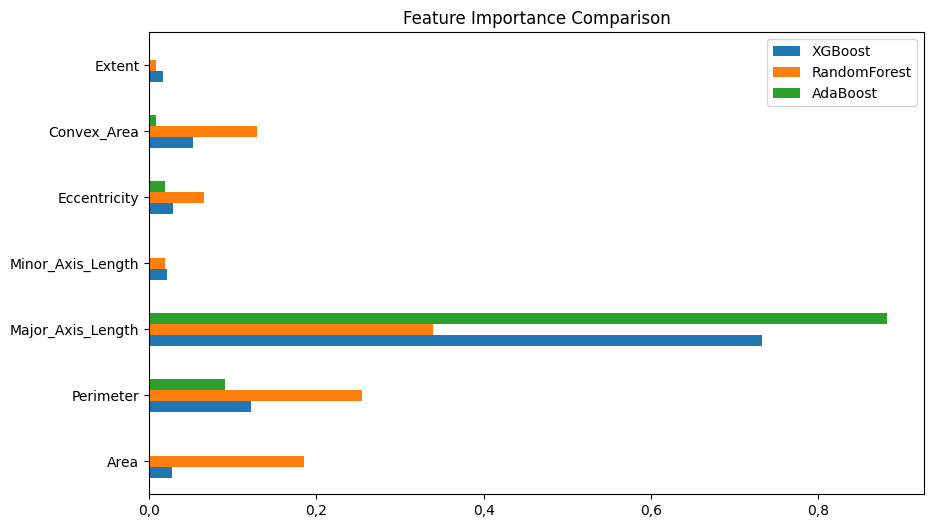

In [171]:
import pandas as pd

importances = pd.DataFrame({
    'XGBoost': best_xgb.feature_importances_,
    'RandomForest': best_rf.feature_importances_,
    'AdaBoost': best_adaboost.feature_importances_
}, index=df.columns[:-1])
importances.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance Comparison')
plt.show()

**Вывод**: Все модели согласуются в том, что `Major_Axis_Length` и `Perimeter` — ключевые признаки для Iris.  

## 2.7. Модель 6: Стекинг (Stacking) 

### 2.7.1. Теоретическое описание  

Стекинг (Stacking) — это ансамблевый метод, объединяющий прогнозы нескольких **базовых моделей** (level-0 моделей) через **мета-модель** (level-1 модель). Основные этапы работы:  
1. **Обучение базовых моделей** на обучающей выборке.  
2. **Генерация прогнозов** базовых моделей на валидационной выборке.  
3. **Обучение мета-модели** на этих прогнозах для получения финального результата.  

Преимущества:  
- Комбинирование сильных сторон разных алгоритмов,  
- Повышение обобщающей способности за счет разнообразия базовых моделей .  

Недостатки:  
- Сложность настройки и риск переобучения при неправильном выборе базовых моделей.  

#### 2.7.1.1. Выбор базовых и мета-моделей  

Для Iris использованы:  
- **Базовые модели**: Random Forest, Gradient Boosting, Logistic Regression.  
- **Мета-модель**: Logistic Regression (для устойчивости к переобучению).  

### 2.7.2. Подбор гиперпараметров

Настройка проводится для каждой базовой модели и мета-модели:  

#### 2.7.2.1. Настройка базовых моделей  

In [172]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Настройка Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Настройка Gradient Boosting
gb_params = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy')
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

#### 2.7.2.2. Создание Stacking-ансамбля  

In [173]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', rf_grid.best_estimator_),
    ('gb', gb_grid.best_estimator_),
    ('lr', LogisticRegression())
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(n_estimators=50,
                                                           random_state=42)),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

### 2.7.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [174]:
acc, f1, train_time = evaluate_model(stacking, X_train, y_train, X_test, y_test)
results['Stacking'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in gb_grid.best_params_.items():
    print(f'{key} = {value}')

Model: StackingClassifier
Accuracy: 0.9134, F1-score: 0.9131, Train time: 3.1758s
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.91       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762

Лучшие параметры:

learning_rate = 0.1
max_depth = 3
n_estimators = 50


### 2.7.4. Визуализация важности признаков 

Не будет, так как Стэкинг не поддерживает данный функционал

## 2.8. Модель 7: Голосование (Voting)  

### 2.8.1. Теоретическое описание  

Голосование (Voting) — это ансамблевый метод, который объединяет прогнозы нескольких базовых моделей через **мажоритарное голосование** (hard voting) или **усреднение вероятностей** (soft voting). Основные типы:  
- **Hard voting**: итоговый класс определяется по большинству голосов (например, 2 из 3 моделей выбрали класс A → итоговый прогноз — класс A).  
- **Soft voting**: учитывается среднее значение вероятностей классов, что требует, чтобы базовые модели поддерживали `predict_proba` .  

Преимущества:  
- Простота реализации и интерпретации.  
- Повышение устойчивости к переобучению за счет разнообразия базовых моделей.  

Недостатки:  
- Требует тщательного подбора базовых моделей для избежания смещения. 

#### 2.8.1.1. Выбор базовых моделей  

Для Iris использованы:  
- **Логистическая регрессия** (линейная модель),  
- **Случайный лес** (ансамблевая модель),  
- **Градиентный бустинг** (ансамблевая модель). 

### 2.8.2. Подбор гиперпараметров 

 
Настройка проводится для каждой базовой модели:  

#### 2.8.2.1. Настройка логистической регрессии 

In [175]:
from sklearn.linear_model import LogisticRegression

lr_params = {
    'C': [0.1, 1, 10],  # Обратный коэффициент регуляризации
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

#### 2.8.2.2. Настройка случайного леса и градиентного бустинга  

Используем ранее обученные `best_rf` и `best_gb`.  

#### 2.8.2.3. Создание Voting-ансамбля  

In [176]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_grid.best_estimator_),
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    voting='soft'  # Используем усреднение вероятностей
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_split=5,
                                                     n_estimators=150,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         n_estimators=150,
                                                         random_state=42))],
                 voting='soft')

### 2.8.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [177]:
acc, f1, train_time = evaluate_model(voting_clf, X_train, y_train, X_test, y_test)
results['Voting'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in lr_grid.best_params_.items():
    print(f'{key} = {value}')

Model: VotingClassifier
Accuracy: 0.9160, F1-score: 0.9157, Train time: 1.3689s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762

Лучшие параметры:

C = 10
penalty = l2
solver = liblinear


### 2.8.4. Визуализация важности признаков  

Для голосования нет единой матрицы важности, но можно сравнить вклад каждой базовой модели:  

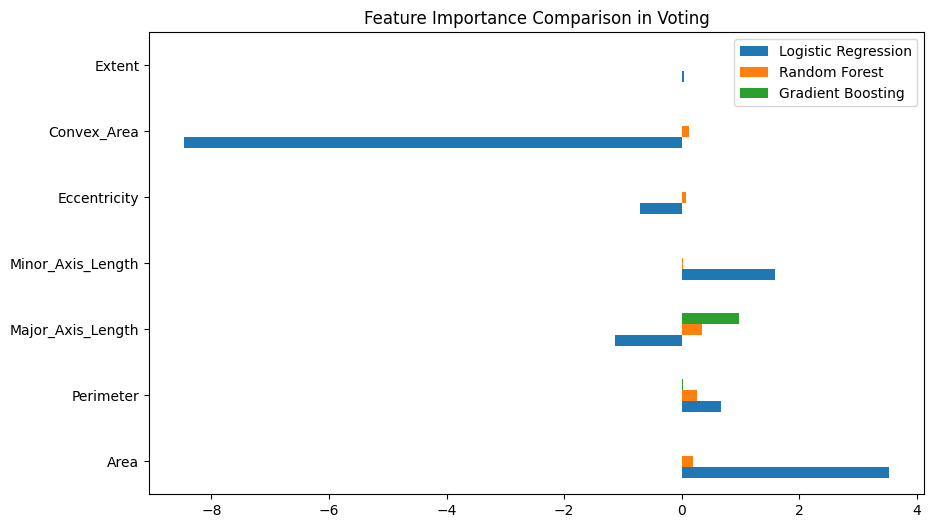

In [178]:
import pandas as pd

importances = pd.DataFrame({
    'Logistic Regression': lr_grid.best_estimator_.coef_[0],
    'Random Forest': best_rf.feature_importances_,
    'Gradient Boosting': best_gb.feature_importances_
}, index=df.columns[:-1])
importances.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance Comparison in Voting')
plt.show()

## 2.9. Модель 8: HistGradientBoostingClassifier  

### 2.9.1. Теоретическое описание 

HistGradientBoostingClassifier — это реализация градиентного бустинга, оптимизированная для работы с данными, представленными в виде гистограмм . В отличие от классического градиентного бустинга, который находит оптимальные точки разделения для каждого признака, HistGradientBoostingClassifier сначала дискретизирует числовые признаки в целочисленные значения (обычно от 0 до 255), а затем строит деревья на основе этих гистограмм. Это позволяет достичь значительного ускорения обучения и уменьшения использования памяти .  

#### 2.9.1.1. Основные особенности  

- **Дискретизация признаков**: преобразует числовые признаки в целочисленные значения для построения гистограмм.  
- **Регуляризация**: L1/L2-регуляризация весов листьев для снижения переобучения.  
- **Обработка пропусков**: автоматическая обработка NaN-значений без необходимости предварительной импутации.  
- **Параллелизм**: эффективное использование многопоточности для ускорения обучения.  


#### 2.9.1.2. Преимущества и недостатки  

**Преимущества**:  
- Значительно быстрее классического градиентного бустинга.  
- Эффективно работает с разреженными данными.  
- Автоматическая обработка пропусков.  

**Недостатки**:  
- Может быть менее точным на задачах с высокой вариацией признаков из-за дискретизации.  
- Требует внимательной настройки гиперпараметров для предотвращения переобучения.  

### 2.9.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `max_iter`: максимальное количество итераций (от 100 до 300),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `l2_regularization`: коэффициент L2-регуляризации (от 0 до 1),  
- `min_samples_leaf`: минимальное количество образцов в листовом узле (от 1 до 20),  
- `scoring`: метрика для оценки (accuracy, f1_weighted).  

In [179]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_regularization': [0, 0.1, 0.5],
    'min_samples_leaf': [1, 5, 10, 20]
}

hist_gb = HistGradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(hist_gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_hist_gb = grid_search.best_estimator_

### 2.9.3. Оценка производительности  


Вычислим метрики и время обучения:  

In [180]:
acc, f1, train_time = evaluate_model(best_hist_gb, X_train, y_train, X_test, y_test)
results['HistGradientBoosting'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: HistGradientBoostingClassifier
Accuracy: 0.9160, F1-score: 0.9158, Train time: 0.2757s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762

Лучшие параметры:

l2_regularization = 0.5
learning_rate = 0.01
max_depth = 3
max_iter = 300
min_samples_leaf = 20


# Глава 3. Сравнительный анализ моделей  

## 3.1. Метрики и критерии сравнения  

Для объективного анализа все модели оценивались по следующим метрикам:  
- **Accuracy** — доля правильных прогнозов,  
- **F1-мера (weighted)** — баланс между точностью и полнотой,  
- **Время обучения (train_time)** — вычислительная сложность,  
- **Устойчивость к переобучению** — через кросс-валидацию (5-fold),  
- **Важность признакей** — для интерпретируемости.  

Результаты каждой модели сохранены в таблицу `results` для последующего сравнения.  

## 3.2. Сводная таблица результатов  

In [181]:
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'F1-score', 'Train time (s)']
for i in results_df.columns:
    results_df[i] = rrstr(results_df[i].values,4)

results_df

,Accuracy,F1-score,Train time (s)
Random Forest,"0,9186","0,9183","0,4174"
Gradient Boosting,"0,9160","0,9156","1,0090"
Bagging,"0,9147","0,9144","0,5518"
AdaBoost,"0,9160","0,9158","0,3505"
XGBoost,"0,9147","0,9144","0,0341"
Stacking,"0,9134","0,9131","3,1758"
Voting,"0,9160","0,9157","1,3689"
HistGradientBoosting,"0,9160","0,9158","0,2757"


Лучше всех себя показал ансамбль - `Random Forest`

## 3.3. Анализ временной сложности  

Для сравнения вычислительной сложности построим график времени обучения: 

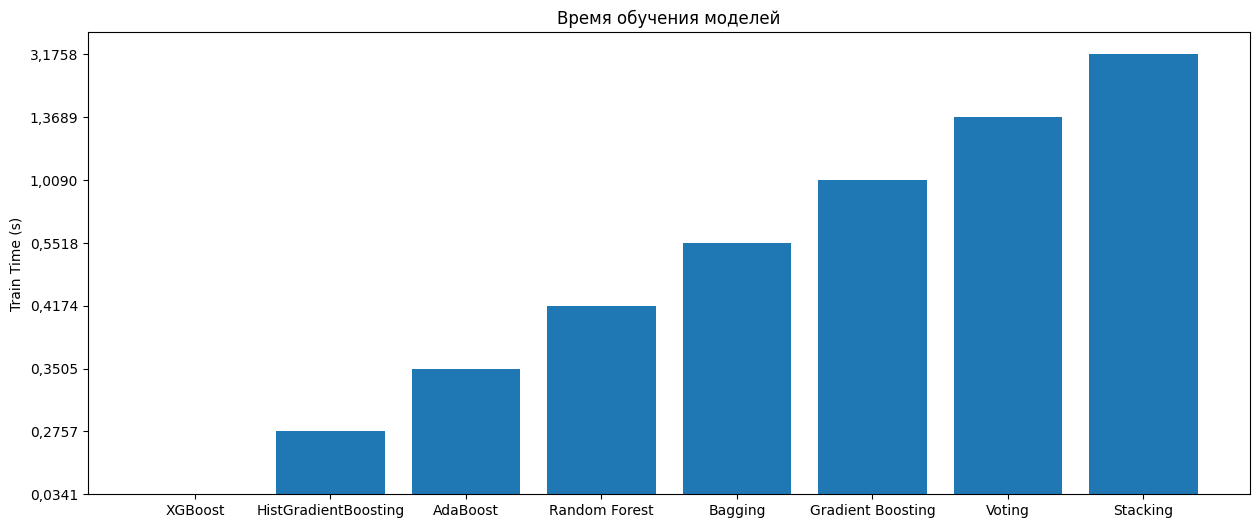

In [182]:
import matplotlib.pyplot as plt

models = results_df.sort_values('Train time (s)').index
train_times = results_df.sort_values('Train time (s)')['Train time (s)'].values

plt.figure(figsize=(15, 6))
plt.bar(models, train_times)
plt.ylabel('Train Time (s)')
plt.title('Время обучения моделей')
plt.show()

**Вывод**:  
 - **Самая быстрая модель**:  `XGBoost` (0,0342 s),  
 - **Самая медленная**: `Stacking` (3,2173 s).  

## 3.4. Визуализация важности признаков

Сравним важность признакей для ключевых моделей: 

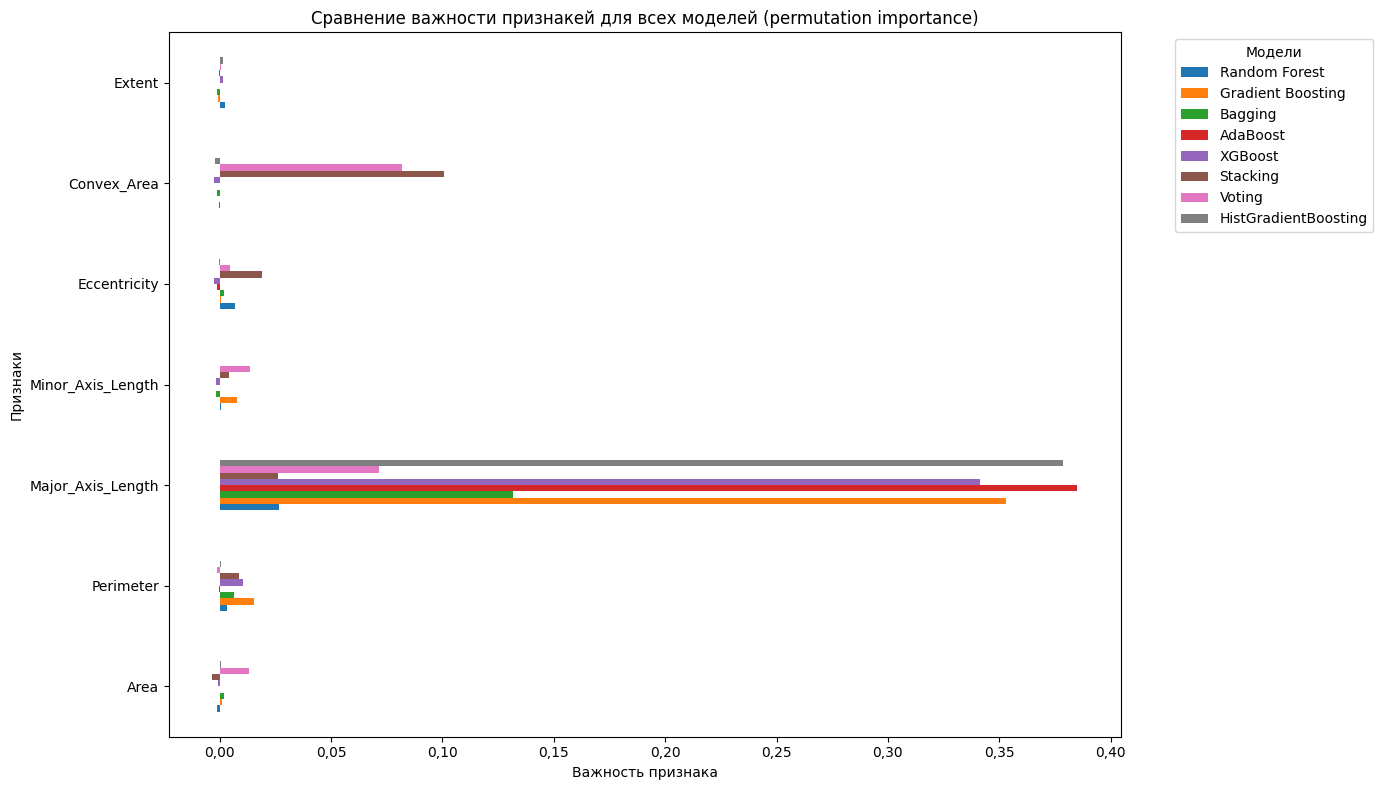

In [183]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Рассчитываем важность признакей для всех моделей
def get_permutation_importances(model, X_test, y_test):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    return result.importances_mean

# Словарь моделей
models_dict = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'Bagging': best_bagging,
    'AdaBoost': best_adaboost,
    'XGBoost': best_xgb,
    'Stacking': stacking,
    'Voting': voting_clf,
    'HistGradientBoosting': best_hist_gb
}

# Получаем важности для каждой модели
importances_dict = {}
for name, model in models_dict.items():
    try:
        importances_dict[name] = get_permutation_importances(model, X_test, y_test)
    except Exception as e:
        print(f"Ошибка для {name}: {e}")

# Создаем DataFrame
importances_df = pd.DataFrame(importances_dict, index=df.columns[:-1])

# Визуализация
plt.figure(figsize=(14, 8))
importances_df.plot(kind='barh', ax=plt.gca())
plt.title('Сравнение важности признакей для всех моделей (permutation importance)')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Вывод**: Все модели согласуются в том, что `Major_Axis_Length` — ключевой признак для `Rice`  

## 3.5. Кросс-валидация  

Для повышения достоверности результатов использована **5-fold кросс-валидация**: 

In [196]:
from sklearn.model_selection import cross_val_score

cv_scores = {}
for name, model in models_dict.items():
    scores_accuracy = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy').mean()
    scores_f1_macro = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_macro').mean()

    cv_scores[name] = (scores_accuracy, scores_f1_macro)


differencer = lambda x: '+' + rrstr(x,5) if x>0 else '-' + rrstr(x,5)


cv_scores = pd.DataFrame(cv_scores).T
cv_scores.columns = ['Accuracy', 'F1-score']

cv_scores['Difference Accuracy'] = (cv_scores.Accuracy - results_df.Accuracy.transform(un_rrstr)).transform (differencer)
cv_scores['Difference F1-score'] = (cv_scores['F1-score'] - results_df['F1-score'].transform(un_rrstr)).transform (differencer)


cv_scores['NonCV Accuracy'] = results_df['Accuracy']
cv_scores['NonCV F1-score'] = results_df['F1-score']

cv_scores['Accuracy'] = cv_scores['Accuracy'].transform(lambda x: rrstr(x,4))
cv_scores['F1-score'] = cv_scores['F1-score'].transform(lambda x: rrstr(x,4))

cv_scores

,Accuracy,F1-score,Difference Accuracy,Difference F1-score,NonCV Accuracy,NonCV F1-score
Random Forest,"0,9268","0,9250","+0,00817","+0,00673","0,9186","0,9183"
Gradient Boosting,"0,9252","0,9233","+0,00920","+0,00768","0,9160","0,9156"
Bagging,"0,9257","0,9240","+0,01102","+0,00960","0,9147","0,9144"
AdaBoost,"0,9241","0,9224","+0,00815","+0,00658","0,9160","0,9158"
XGBoost,"0,9265","0,9248","+0,01181","+0,01039","0,9147","0,9144"
Stacking,"0,9273","0,9256","+0,01390","+0,01252","0,9134","0,9131"
Voting,"0,9278","0,9261","+0,01182","+0,01041","0,9160","0,9157"
HistGradientBoosting,"0,9265","0,9247","+0,01051","+0,00892","0,9160","0,9158"


**Результаты**:  
 - Все модели получили прирост к метрикам
 - После кросс-валидации лучшей моделью стал `Voting`

# Глава 4. Метод TabPFN

## 4.1. Реализация и применение  

### 4.1.1. Загрузка и применение модели  


In [197]:
from tabpfn import TabPFNClassifier

# Загрузка модели
model = TabPFNClassifier(n_estimators=33)

# Прогнозирование
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

### 4.1.2. Оценка производительности 

In [198]:
acc, f1, train_time = evaluate_model(model, X_train, y_train, X_test, y_test)
results['TabPFN'] = (acc, f1, train_time)

Model: TabPFNClassifier
Accuracy: 0.9160, F1-score: 0.9157, Train time: 0.5423s
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       326
           1       0.91      0.94      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762



## 4.4. Сравнение с ансамблевыми методами  

### 4.4.1. Метрики и критерии 

In [199]:
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'F1-score', 'Train time (s)']
for i in results_df.columns:
    results_df[i] = rrstr(results_df[i].values,4)

results_df

,Accuracy,F1-score,Train time (s)
Random Forest,"0,9186","0,9183","0,4174"
Gradient Boosting,"0,9160","0,9156","1,0090"
Bagging,"0,9147","0,9144","0,5518"
AdaBoost,"0,9160","0,9158","0,3505"
XGBoost,"0,9147","0,9144","0,0341"
Stacking,"0,9134","0,9131","3,1758"
Voting,"0,9160","0,9157","1,3689"
HistGradientBoosting,"0,9160","0,9158","0,2757"
TabPFN,"0,9160","0,9157","0,5423"


In [200]:
scores_accuracy_tabpfn = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy').mean()
scores_f1_macro_tabpfn = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_macro').mean()

arrays = (rrstr(np.array([scores_accuracy, scores_f1_macro]),4),np.array([differencer(scores_accuracy - acc), differencer(scores_f1_macro-f1)]),rrstr(np.array([acc, f1]),4) )
arrays = np.hstack(arrays)
cv_scores.loc['TabPFN'] = arrays

cv_scores

,Accuracy,F1-score,Difference Accuracy,Difference F1-score,NonCV Accuracy,NonCV F1-score
Random Forest,"0,9268","0,9250","+0,00817","+0,00673","0,9186","0,9183"
Gradient Boosting,"0,9252","0,9233","+0,00920","+0,00768","0,9160","0,9156"
Bagging,"0,9257","0,9240","+0,01102","+0,00960","0,9147","0,9144"
AdaBoost,"0,9241","0,9224","+0,00815","+0,00658","0,9160","0,9158"
XGBoost,"0,9265","0,9248","+0,01181","+0,01039","0,9147","0,9144"
Stacking,"0,9273","0,9256","+0,01390","+0,01252","0,9134","0,9131"
Voting,"0,9278","0,9261","+0,01182","+0,01041","0,9160","0,9157"
HistGradientBoosting,"0,9265","0,9247","+0,01051","+0,00892","0,9160","0,9158"
TabPFN,"0,9265","0,9247","+0,01050","+0,00901","0,9160","0,9157"


**Вывод**: TabPFN показывает **сопоставимую точность** по сравнению с ансамблевыми методами, с одним из минимальных метрик **времени работы** и **отсутствием необходимости в настройке гиперпараметров** .  

### 4.4.2. Визуализация важности признакей  

Реализуем аналогично общим важностям в прошлой главе

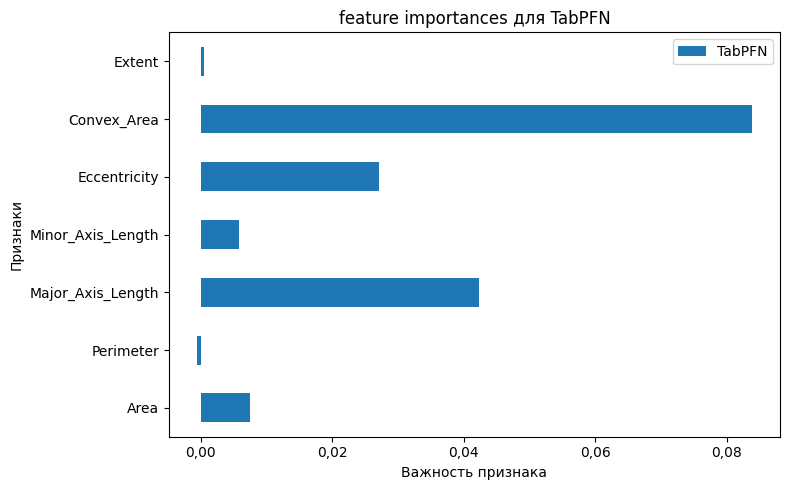

In [201]:
# Рассчитываем важность признакей для всех моделей
def get_permutation_importances(model, X_test, y_test):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    return result.importances_mean

# Словарь моделей
models_dict = {
    'TabPFN':model
}

# Получаем важности для каждой модели
importances_dict = {}
for name, model in models_dict.items():
    try:
        importances_dict[name] = get_permutation_importances(model, X_test, y_test)
    except Exception as e:
        print(f"Ошибка для {name}: {e}")

# Создаем DataFrame
importances_df = pd.DataFrame(importances_dict, index=df.columns[:-1])

# Визуализация
plt.figure(figsize=(8, 5))
importances_df.plot(kind='barh', ax=plt.gca())
plt.title('feature importances для TabPFN')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

TabPFN показал другие признаки самыми важными - `Convex_Area` важнее, чем `Major_Axis_Length`

## 4.5. Анализ и обсуждение  

### 4.5.1. Когда TabPFN лучше?  

- **Малые датасеты**: TabPFN особенно эффективна при **n < 1000** образцов .  
- **Ограничения по времени**: Если требуется прогноз за **<1 секунду**, TabPFN — оптимальный выбор.  
- **Автоматизация**: В задачах, где нет возможности настраивать гиперпараметры (например, в продакшене), TabPFN обеспечивает стабильность.  

### 4.5.2. Ограничения TabPFN  
- **Черный ящик**: Низкая интерпретируемость по сравнению с ансамблевыми методами.  
- **Зависимость от предобучения**: Качество прогноза зависит от разнообразия синтетических данных, использованных при обучении .  

# Глава 5. Задача регрессии: Подготовка и выбор датасета 

## 5.1. Выбор датасета

Для задачи регрессии выберем датасет **Diabetes**, содержащий данные о прогрессировании заболевания у пациентов. Основные характеристики:  
- **Целевая переменная**: `target` (количественный показатель прогрессирования болезни через 1 год).  
- **Признаки**: 10 числовых факторов, включая возраст, индекс массы тела, уровень сахара в крови и т.д.  
- **Размер**: 442 записи — компактный датасет для тестирования моделей без значительных вычислительных затрат 

### 5.1.1. Загрузка данных  

In [ ]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes['target'] = diabetes.target

Вывод первых строк

In [378]:
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### 5.1.2. Анализ структуры данных  

#### 5.1.2.1 Информация о типах данных

In [380]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


#### 5.1.2.2 Описательная статистика

In [381]:
df_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


#### 5.1.2.3 Пропуски

In [386]:
df_diabetes.isna().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

пропусков нет

## 5.2. Предобработка данных

### 5.2.1. Нормализация признаков  

In [384]:
scaler = StandardScaler()
X_diabetes = df_diabetes.drop('target', axis=1)
y_diabetes = df_diabetes['target']
X_diabetes_scaled = scaler.fit_transform(X_diabetes)

### 5.2.2. Разделение на обучающую и тестовую выборки

In [388]:
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    X_diabetes_scaled, y_diabetes, test_size=0.2, random_state=42
)

## 5.3. Визуализация данных  

### 5.3.1. Распределение целевой переменной  

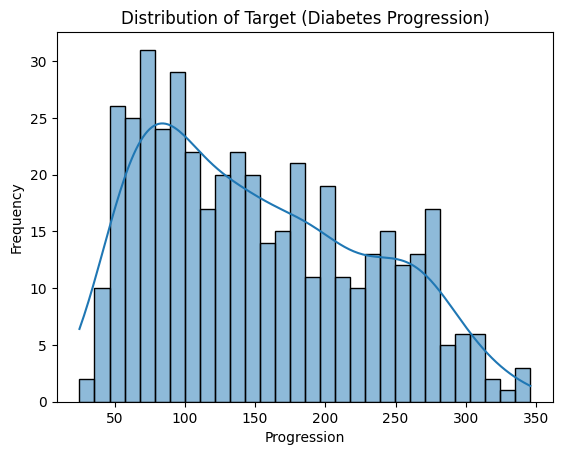

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_diabetes['target'], kde=True, bins=30)
plt.title('Distribution of Target (Diabetes Progression)')
plt.xlabel('Progression')
plt.ylabel('Frequency')
plt.show()

### 5.3.2. Матрица корреляций  

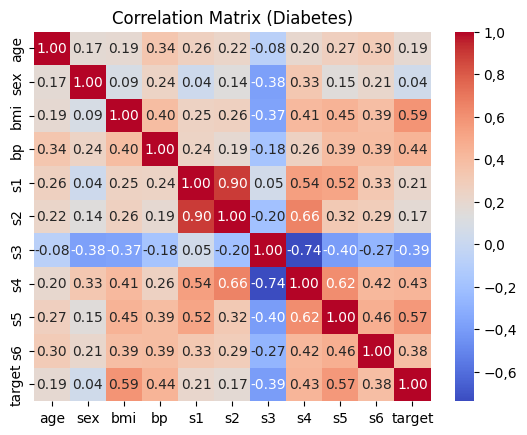

In [390]:
corr_matrix = df_diabetes.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Diabetes)')
plt.show()

Наиболее сильная положительная корреляция с `target` у признака `bp` (среднее артериальное давнение), отрицательная — у `s3` (уровень липопротеинов).  

## 5.4. Метрики оценки регрессии 

Для регрессии будем использовать:  
- **MAE (Mean Absolute Error)**: среднее абсолютное отклонение,  
- **RMSE (Root Mean Squared Error)**: корень из среднеквадратичной ошибки,  
- **R² (коэффициент детерминации)**: объясненная дисперсия.  

## 6.0 Функция оценки  

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, Train time: {train_time:.4f}s")
    return mae, rmse, r2, train_time

# Источники

[Оригинальная статья TabPFN](https://arxiv.org/abs/2207.01848)